# Introduction to SVI

## Prepare Notebook

In [1]:
from itertools import pairwise

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax
import seaborn as sns
import xarray as xr
from flax import nnx
from jax import random
from jaxtyping import Array, Float, Int
from numpyro.contrib.module import random_nnx_module
from numpyro.handlers import condition
from numpyro.infer import SVI, Predictive, Trace_ELBO
from sklearn.datasets import make_moons
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

seed = 42
rng_key = random.PRNGKey(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

## Generate Synthetic Data

In [2]:
# Generate data
n_samples = 2_000
x, y = make_moons(n_samples=n_samples, noise=0.3, random_state=seed)

# Split data into training, validation, and test sets
x_train_all, x_test, y_train_all, y_test = train_test_split(
    x, y, test_size=0.3, random_state=seed
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_all, y_train_all, test_size=0.3, random_state=seed
)

# Get number of samples in training and test sets
n_train = x_train.shape[0]
n_val = x_val.shape[0]
n_test = x_test.shape[0]
n = n_train + n_val + n_test

# Parse as JAX arrays
x_train: Float[Array, "n_train 2"] = jnp.array(x_train)
x_val: Float[Array, "n_val 2"] = jnp.array(x_val)
x_test: Float[Array, "n_test 2"] = jnp.array(x_test)
y_train: Int[Array, "n_train"] = jnp.array(y_train)
y_val: Int[Array, "n_val"] = jnp.array(y_val)
y_test: Int[Array, "n_test"] = jnp.array(y_test)


# Create indices for training and test sets
idx_train = range(n_train)
idx_val = range(n_train, n_train + n_val)
idx_test = range(n_train + n_val, n_train + n_val + n_test)

Let's start by visualizing the data.

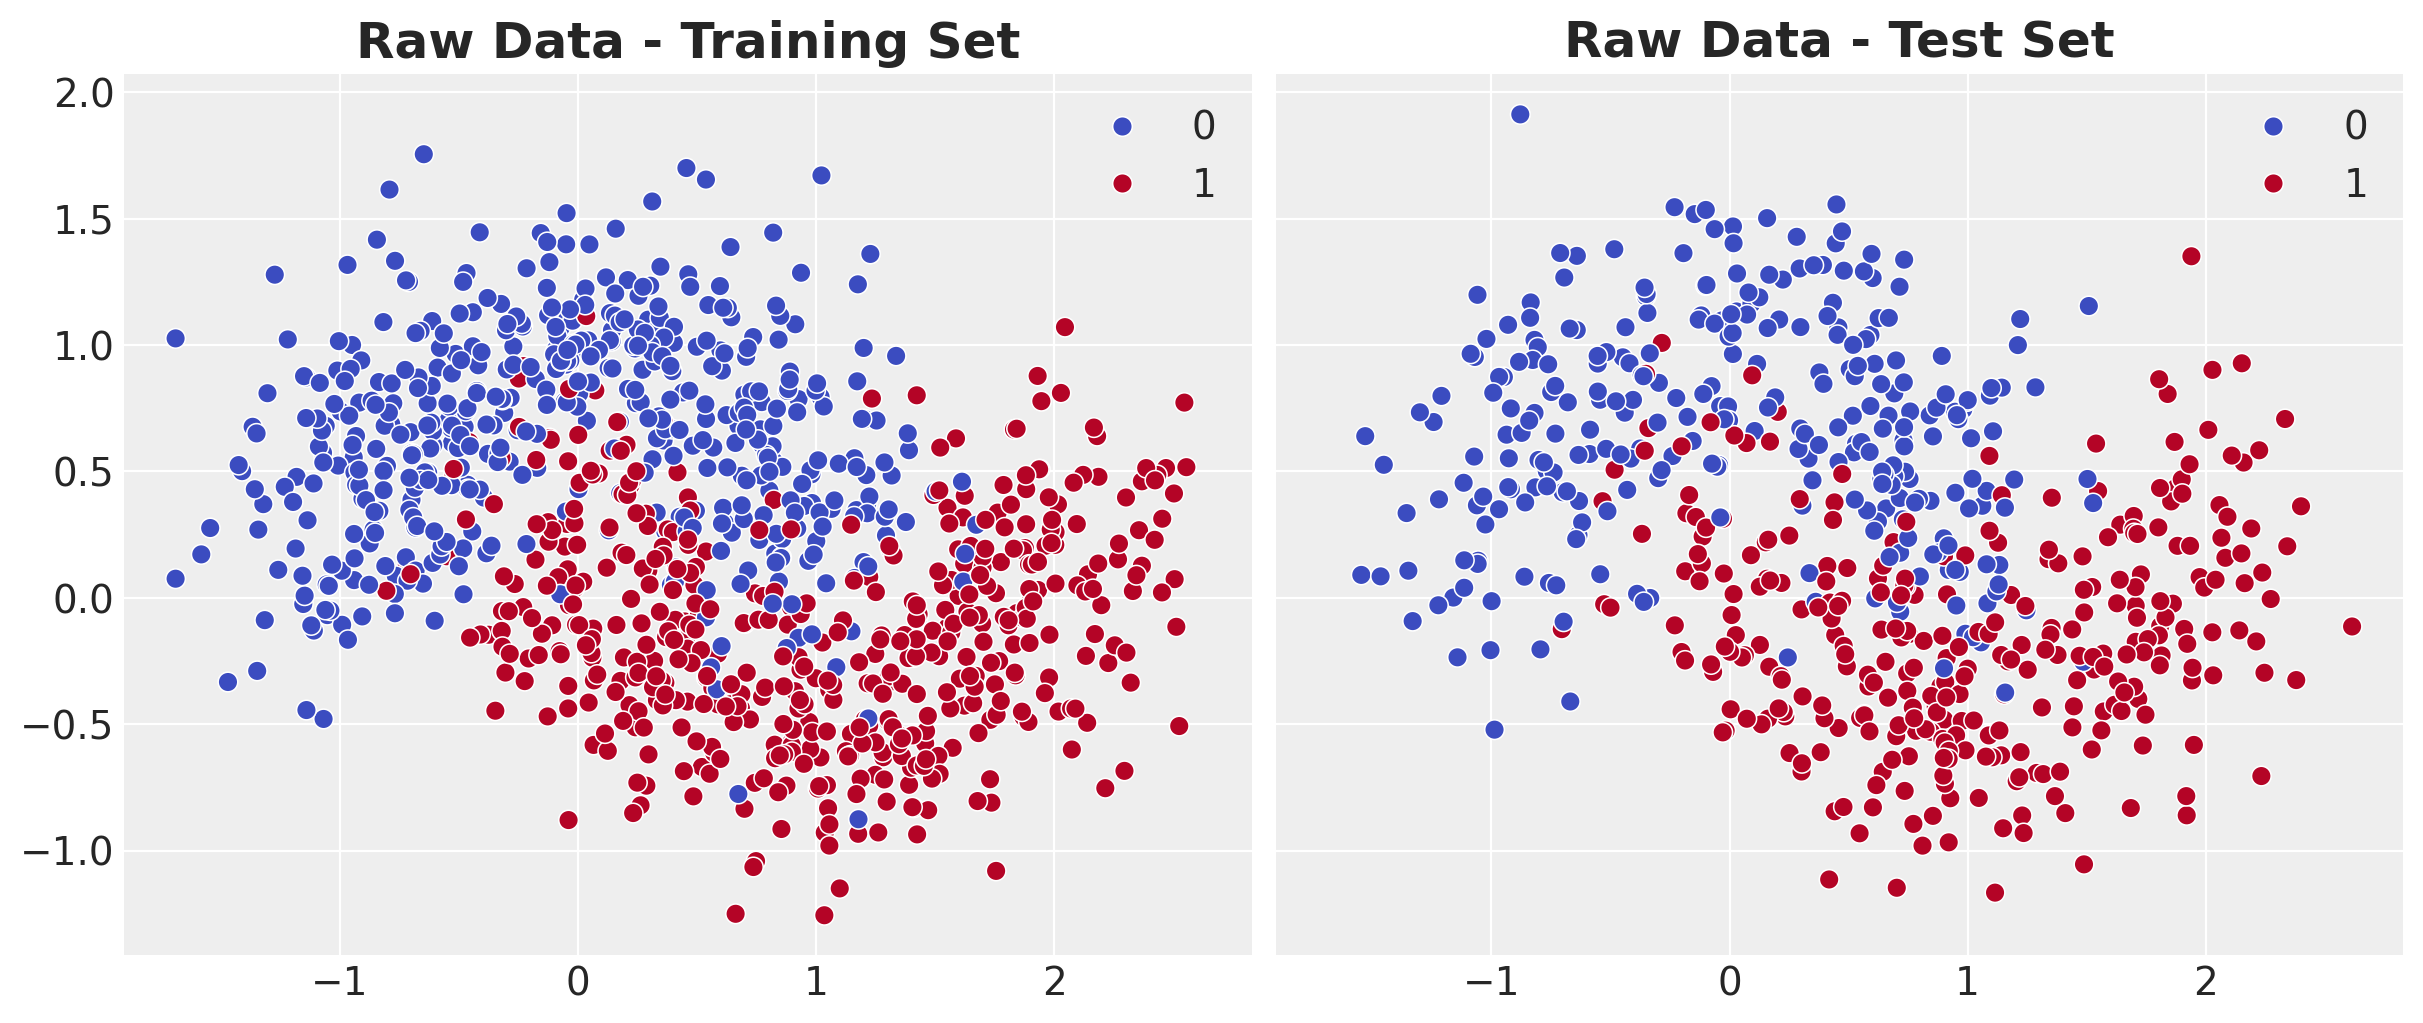

In [3]:
cmap = mpl.colormaps["coolwarm"]
colors = list(cmap(np.linspace(0, 1, 2)))

fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 5),
    sharex=True,
    sharey=True,
    layout="constrained",
)

sns.scatterplot(
    x=x_train[:, 0], y=x_train[:, 1], s=50, hue=y_train, palette=colors, ax=ax[0]
)
ax[0].set_title("Raw Data - Training Set", fontsize=18, fontweight="bold")

sns.scatterplot(
    x=x_test[:, 0], y=x_test[:, 1], s=50, hue=y_test, palette=colors, ax=ax[1]
)
ax[1].set_title("Raw Data - Test Set", fontsize=18, fontweight="bold");

The idea is to develop a classifier to separate the two classes in the moons dataset.

## Model Specification




In [4]:
class MLP(nnx.Module):
    def __init__(self, din, dout, hidden_layers, *, rngs):
        self.layers = []
        layer_dims = [din, *hidden_layers, dout]
        for in_dim, out_dim in pairwise(layer_dims):
            self.layers.append(nnx.Linear(in_dim, out_dim, rngs=rngs))

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.tanh(layer(x))
        return jax.nn.sigmoid(self.layers[-1](x))

In [5]:
rng_key, rng_subkey = random.split(rng_key)

n_layers = 2

nnx_module = MLP(
    din=x_train.shape[1],
    dout=1,
    hidden_layers=[n_layers, 1],
    rngs=nnx.Rngs(rng_subkey),
)

In [6]:
def model(x: Float[Array, "n_obs features"]) -> None:
    n_obs: int = x.shape[0]

    def prior(name, shape):
        return (
            dist.Normal(loc=0, scale=1)
            if "bias" in name
            else dist.SoftLaplace(loc=0, scale=1)
        )

    nn = random_nnx_module("nn", nnx_module, prior=prior)

    p = numpyro.deterministic("p", nn(x).squeeze(-1))

    with numpyro.plate("data", n_obs):
        numpyro.sample("y", dist.Bernoulli(probs=p))

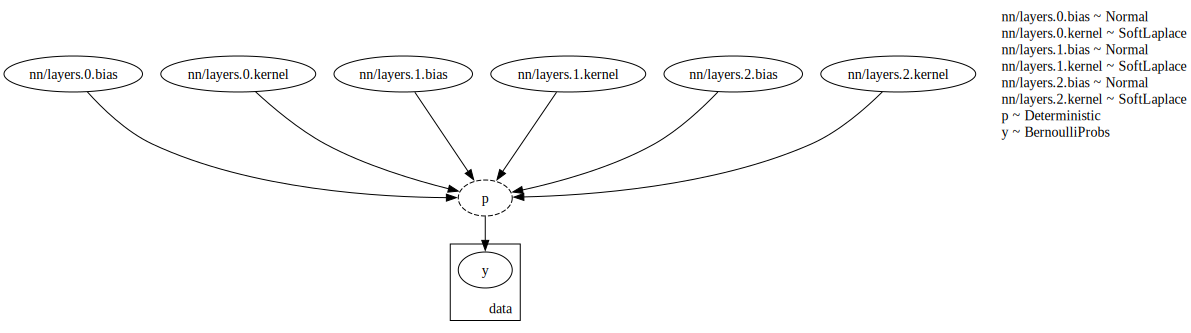

In [7]:
numpyro.render_model(
    model=model,
    model_kwargs={
        "x": x_train,
    },
    render_distributions=True,
    render_params=True,
)

In [8]:
conditioned_model = condition(model, {"y": y_train})

In [21]:
def layer_guide(
    loc_shape: tuple[int, ...],
    loc_amplitude: float,
    scale_shape: tuple[int, ...],
    scale_amplitude: float,
    loc_name: str,
    scale_name: str,
    layer_name: str,
    event_shape: int = 1,
) -> None:
    loc = numpyro.param(loc_name, loc_amplitude * jnp.ones(shape=loc_shape))
    scale = numpyro.param(
        scale_name,
        scale_amplitude * jnp.ones(shape=scale_shape),
        constraint=dist.constraints.positive,
    )
    numpyro.sample(
        layer_name,
        dist.Normal(loc=loc, scale=scale).to_event(event_shape),
    )


def guide(x: Float[Array, "n_obs features"]) -> None:
    layer_guide(
        loc_shape=(n_layers,),
        loc_amplitude=0.5,
        scale_shape=(n_layers,),
        scale_amplitude=0.2,
        loc_name="nn/layers.0.bias_auto_loc",
        scale_name="nn/layers.0.bias_auto_scale",
        layer_name="nn/layers.0.bias",
        event_shape=1,
    )
    layer_guide(
        loc_shape=(x.shape[1], n_layers),
        loc_amplitude=0.5,
        scale_shape=(x.shape[1], n_layers),
        scale_amplitude=0.2,
        loc_name="nn/layers.0.kernel_auto_loc",
        scale_name="nn/layers.0.kernel_auto_scale",
        layer_name="nn/layers.0.kernel",
        event_shape=2,
    )
    layer_guide(
        loc_shape=(1,),
        loc_amplitude=0.5,
        scale_shape=(1,),
        scale_amplitude=0.2,
        loc_name="nn/layers.1.bias_auto_loc",
        scale_name="nn/layers.1.bias_auto_scale",
        layer_name="nn/layers.1.bias",
        event_shape=1,
    )
    layer_guide(
        loc_shape=(n_layers, 1),
        loc_amplitude=0.5,
        scale_shape=(n_layers, 1),
        scale_amplitude=0.2,
        loc_name="nn/layers.1.kernel_auto_loc",
        scale_name="nn/layers.1.kernel_auto_scale",
        layer_name="nn/layers.1.kernel",
        event_shape=2,
    )
    layer_guide(
        loc_shape=(1,),
        loc_amplitude=0.5,
        scale_shape=(1,),
        scale_amplitude=0.2,
        loc_name="nn/layers.2.bias_auto_loc",
        scale_name="nn/layers.2.bias_auto_scale",
        layer_name="nn/layers.2.bias",
        event_shape=1,
    )
    layer_guide(
        loc_shape=(1, 1),
        loc_amplitude=0.5,
        scale_shape=(1, 1),
        scale_amplitude=0.2,
        loc_name="nn/layers.2.kernel_auto_loc",
        scale_name="nn/layers.2.kernel_auto_scale",
        layer_name="nn/layers.2.kernel",
        event_shape=2,
    )

100%|██████████| 8000/8000 [00:01<00:00, 4487.63it/s, init loss: 723.5276, avg. loss [7601-8000]: 357.7275]


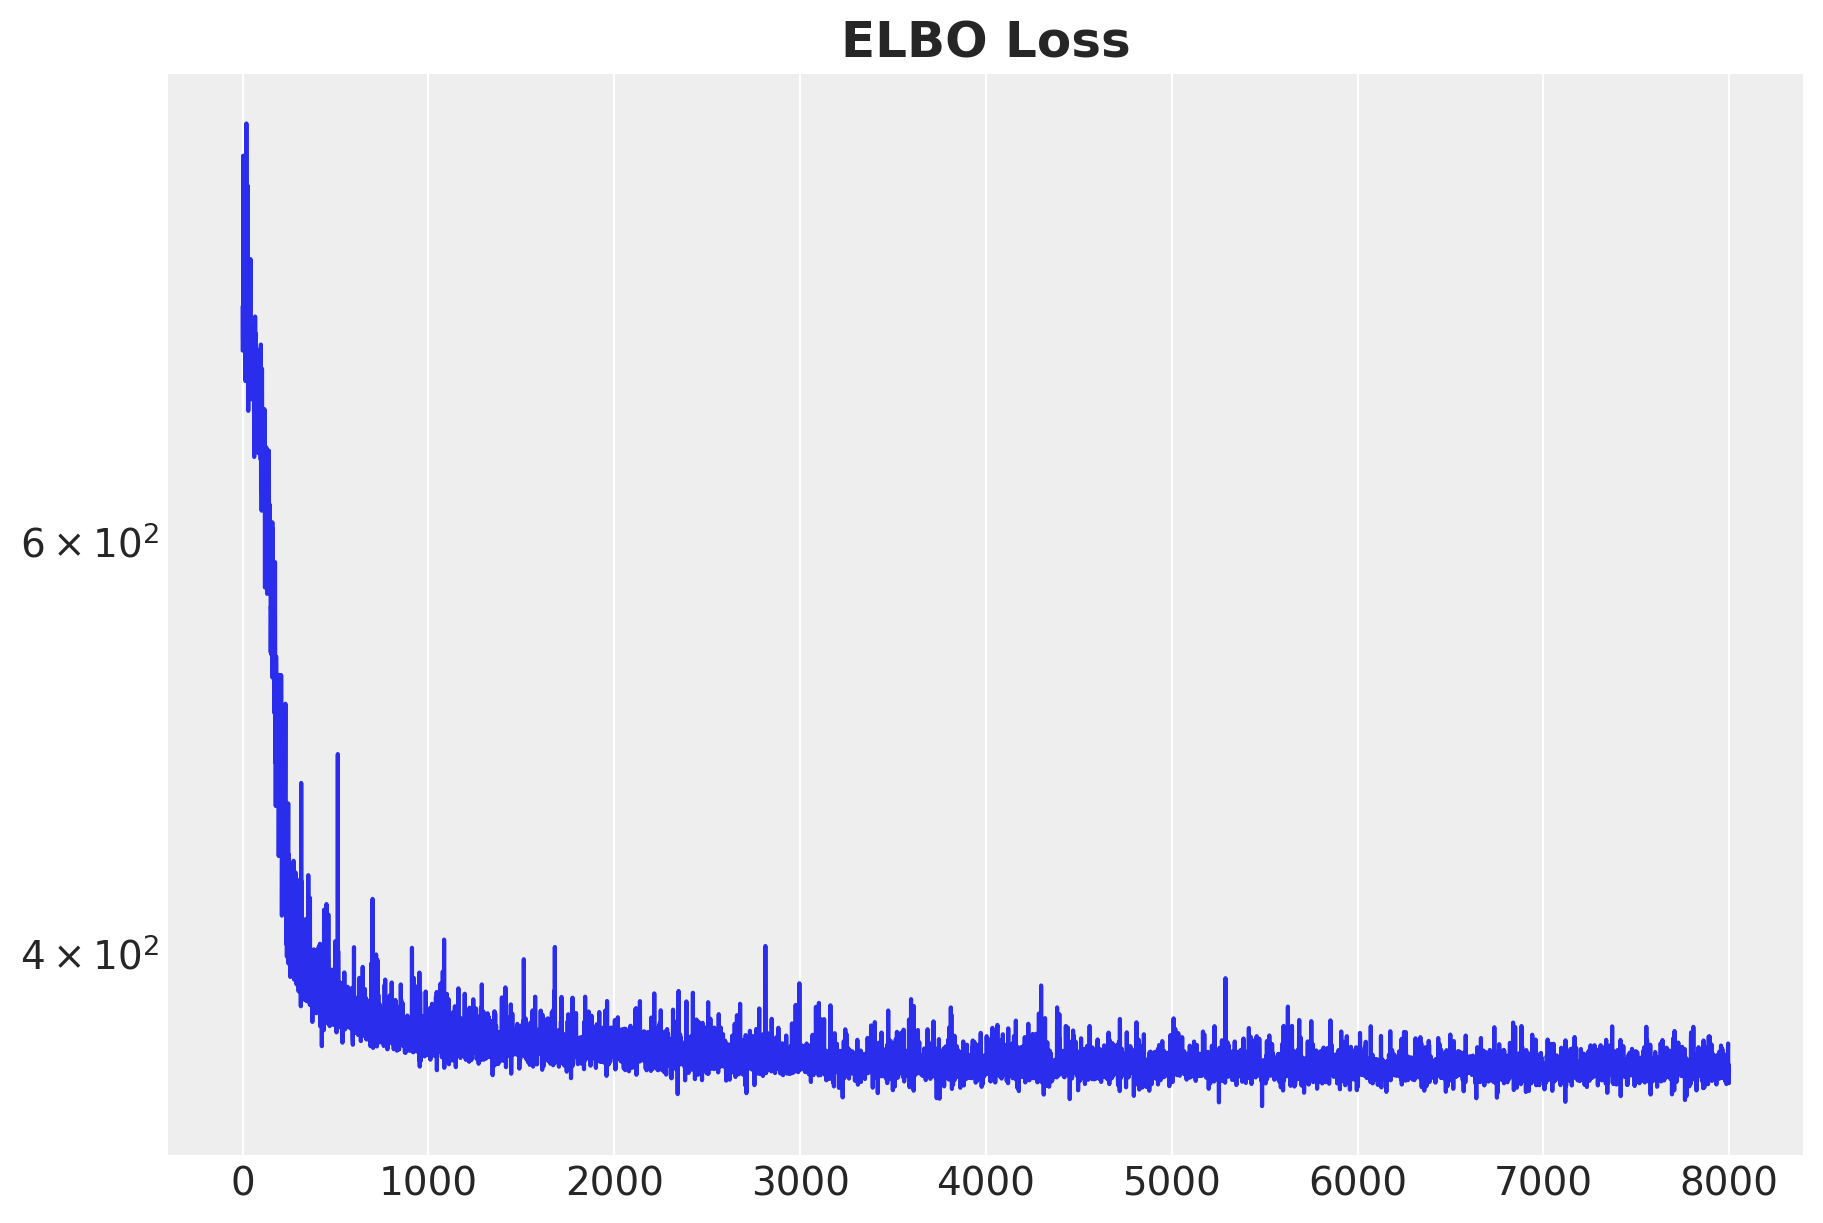

In [22]:
scheduler = optax.linear_onecycle_schedule(
    transition_steps=8_000,
    peak_value=0.008,
    pct_start=0.008,
    pct_final=0.8,
    div_factor=3,
    final_div_factor=4,
)

optimizer = optax.chain(
    optax.adam(learning_rate=scheduler),
    optax.contrib.reduce_on_plateau(
        factor=0.1,
        patience=10,
        accumulation_size=100,
    ),
)

svi = SVI(conditioned_model, guide, optimizer, loss=Trace_ELBO())
n_samples = 8_000
rng_key, rng_subkey = random.split(key=rng_key)
svi_result = svi.run(rng_subkey, n_samples, x=x_train)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set(yscale="log")
ax.set_title("ELBO Loss", fontsize=18, fontweight="bold");

In [13]:
params = svi_result.params

train_posterior_predictive = Predictive(
    model=model,
    guide=guide,
    params=params,
    num_samples=2_000,
    return_sites=["p", "y"],
)

rng_key, rng_subkey = random.split(key=rng_key)
train_posterior_predictive_samples = train_posterior_predictive(rng_subkey, x_train)

train_idata = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in train_posterior_predictive_samples.items()
    },
    coords={"obs_idx": idx_train},
    dims={
        "p": ["obs_idx"],
        "y": ["obs_idx"],
    },
)

In [14]:
test_posterior_predictive = Predictive(
    model=model,
    guide=guide,
    params=params,
    num_samples=2_000,
    return_sites=["p", "y"],
)

rng_key, rng_subkey = random.split(key=rng_key)
test_posterior_predictive_samples = test_posterior_predictive(rng_subkey, x_test)

test_idata = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in test_posterior_predictive_samples.items()
    },
    coords={"obs_idx": idx_test},
    dims={
        "p": ["obs_idx"],
        "y": ["obs_idx"],
    },
)

In [15]:
auc_train = xr.apply_ufunc(
    roc_auc_score,
    y_train,
    train_idata["posterior_predictive"]["p"],
    input_core_dims=[["obs_idx"], ["obs_idx"]],
    output_core_dims=[[]],
    vectorize=True,
)

auc_test = xr.apply_ufunc(
    roc_auc_score,
    y_test,
    test_idata["posterior_predictive"]["p"],
    input_core_dims=[["obs_idx"], ["obs_idx"]],
    output_core_dims=[[]],
    vectorize=True,
)

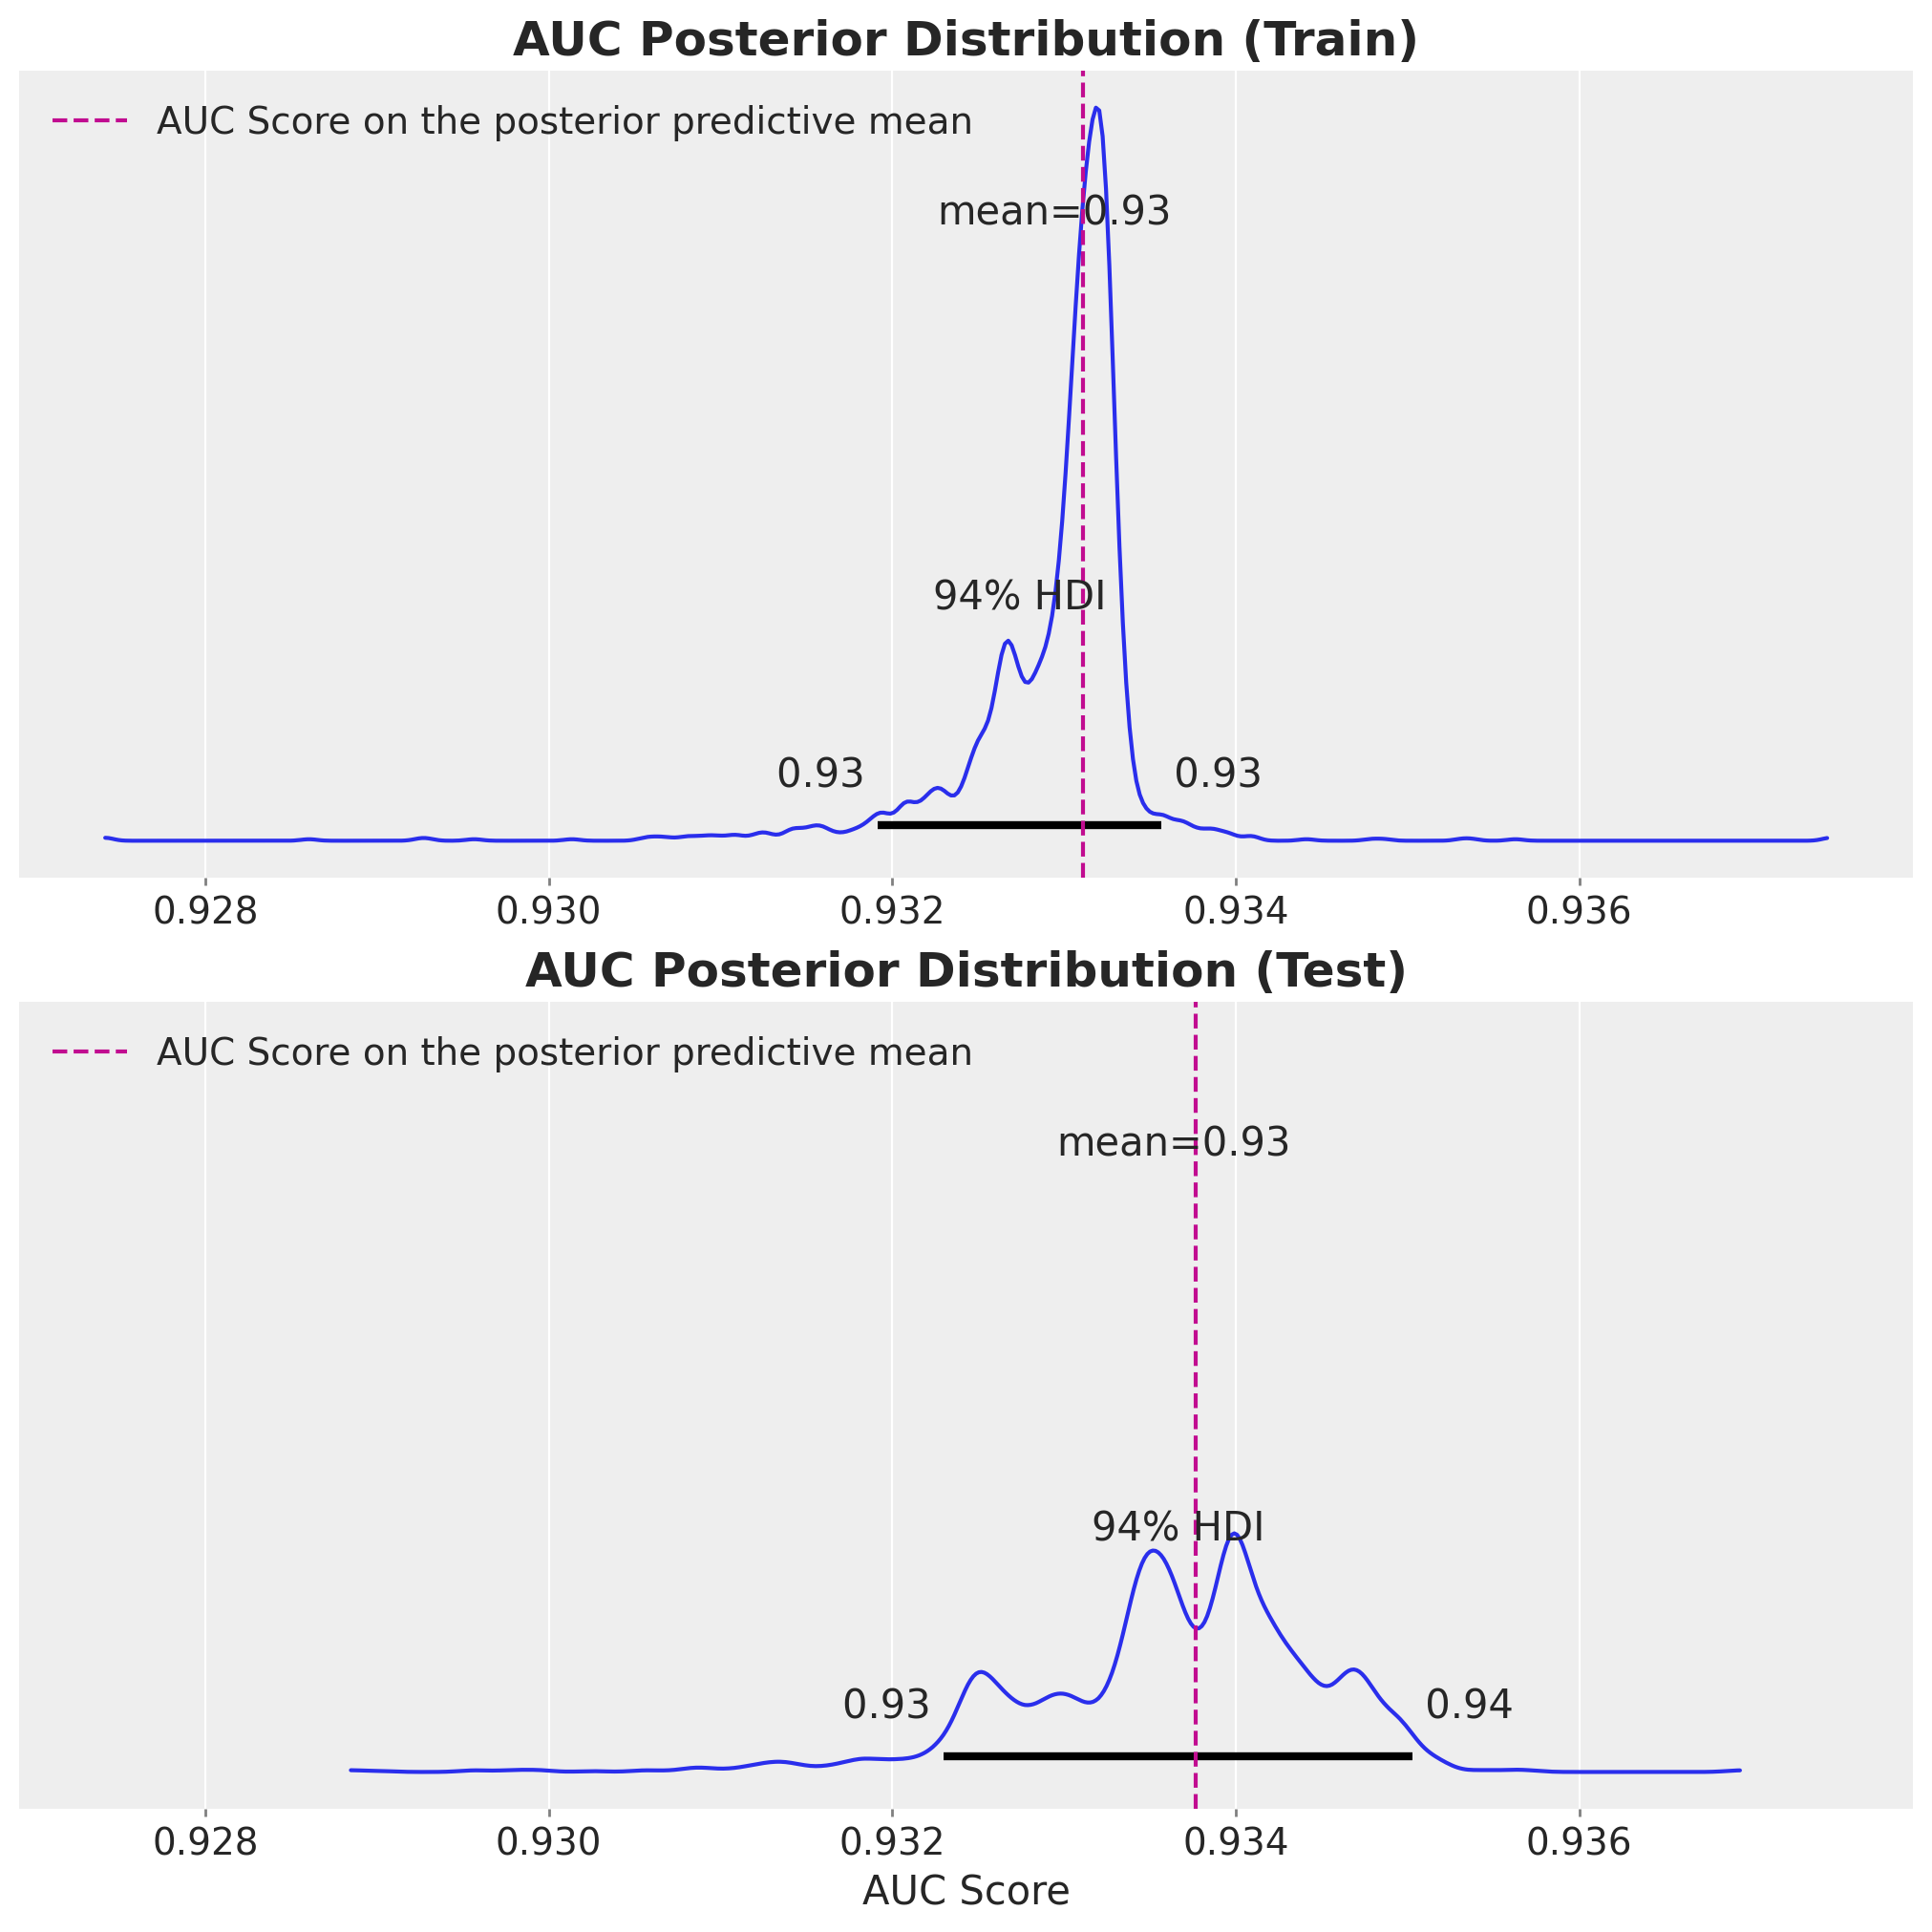

In [16]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 10),
    sharex=True,
    sharey=True,
    layout="constrained",
)
az.plot_posterior(data=auc_train, ax=ax[0])
ax[0].axvline(
    roc_auc_score(
        y_train, train_idata["posterior_predictive"]["p"].mean(dim=("chain", "draw"))
    ),
    color="C3",
    linestyle="--",
    label="AUC Score on the posterior predictive mean",
)
ax[0].legend(loc="upper left")
ax[0].set_title("AUC Posterior Distribution (Train)", fontsize=18, fontweight="bold")

az.plot_posterior(data=auc_test, ax=ax[1])
ax[1].axvline(
    roc_auc_score(
        y_test, test_idata["posterior_predictive"]["p"].mean(dim=("chain", "draw"))
    ),
    color="C3",
    linestyle="--",
    label="AUC Score on the posterior predictive mean",
)
ax[1].legend(loc="upper left")
ax[1].set(xlabel="AUC Score")
ax[1].set_title("AUC Posterior Distribution (Test)", fontsize=18, fontweight="bold");

In [17]:
def _roc_curve(y_true, y_score):
    n = y_true.shape[0] - 1
    fpr, tpr, thresholds = roc_curve(
        y_true=y_true, y_score=y_score, drop_intermediate=False
    )
    return fpr[:n], tpr[:n], thresholds[:n]

In [18]:
fpr_train, tpr_train, thresholds_train = xr.apply_ufunc(
    lambda x, y: _roc_curve(y_true=x, y_score=y),
    y_train,
    train_idata["posterior_predictive"]["p"],
    input_core_dims=[["obs_idx"], ["obs_idx"]],
    output_core_dims=[["threshld"], ["threshld"], ["threshld"]],
    vectorize=True,
)

fpr_test, tpr_test, thresholds_test = xr.apply_ufunc(
    lambda x, y: _roc_curve(y_true=x, y_score=y),
    y_test,
    test_idata["posterior_predictive"]["p"],
    input_core_dims=[["obs_idx"], ["obs_idx"]],
    output_core_dims=[["threshld"], ["threshld"], ["threshld"]],
    vectorize=True,
)

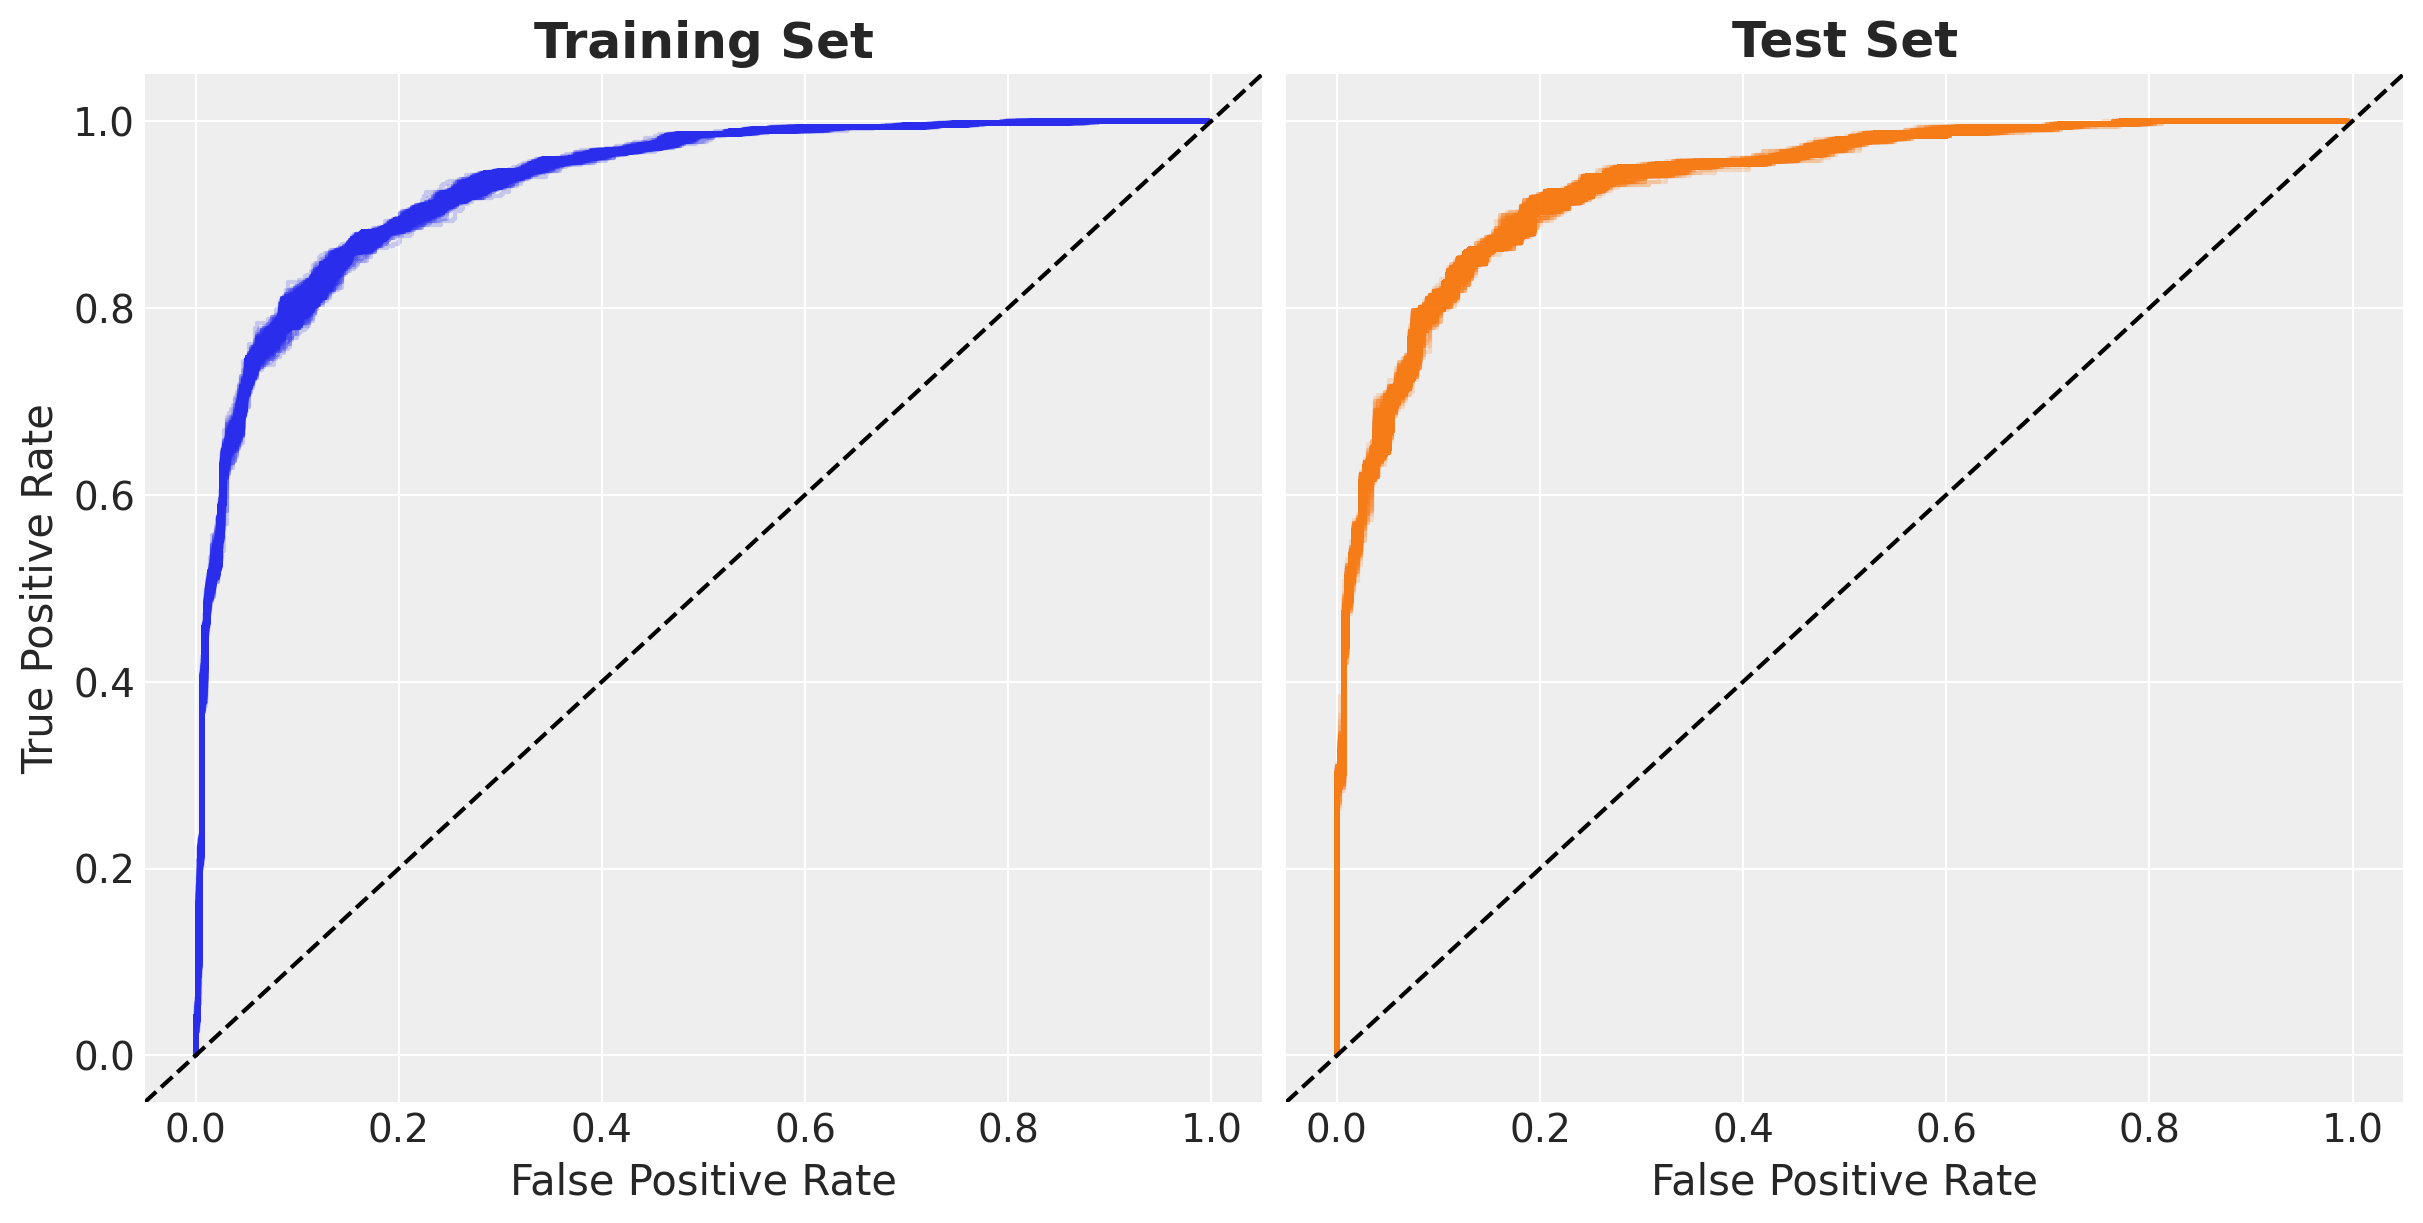

In [19]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 6),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in range(2_000):
    ax[0].plot(
        fpr_train.sel(chain=0, draw=i),
        tpr_train.sel(chain=0, draw=i),
        c="C0",
        alpha=0.2,
    )
    ax[1].plot(
        fpr_test.sel(chain=0, draw=i),
        tpr_test.sel(chain=0, draw=i),
        c="C1",
        alpha=0.2,
    )


ax[0].axline(
    (0, 0),
    (1, 1),
    color="black",
    linestyle="--",
)

ax[0].set(xlabel="False Positive Rate", ylabel="True Positive Rate")
ax[0].set_title("Training Set", fontsize=18, fontweight="bold")

ax[1].axline(
    (0, 0),
    (1, 1),
    color="black",
    linestyle="--",
)

ax[1].set(xlabel="False Positive Rate")
ax[1].set_title("Test Set", fontsize=18, fontweight="bold");

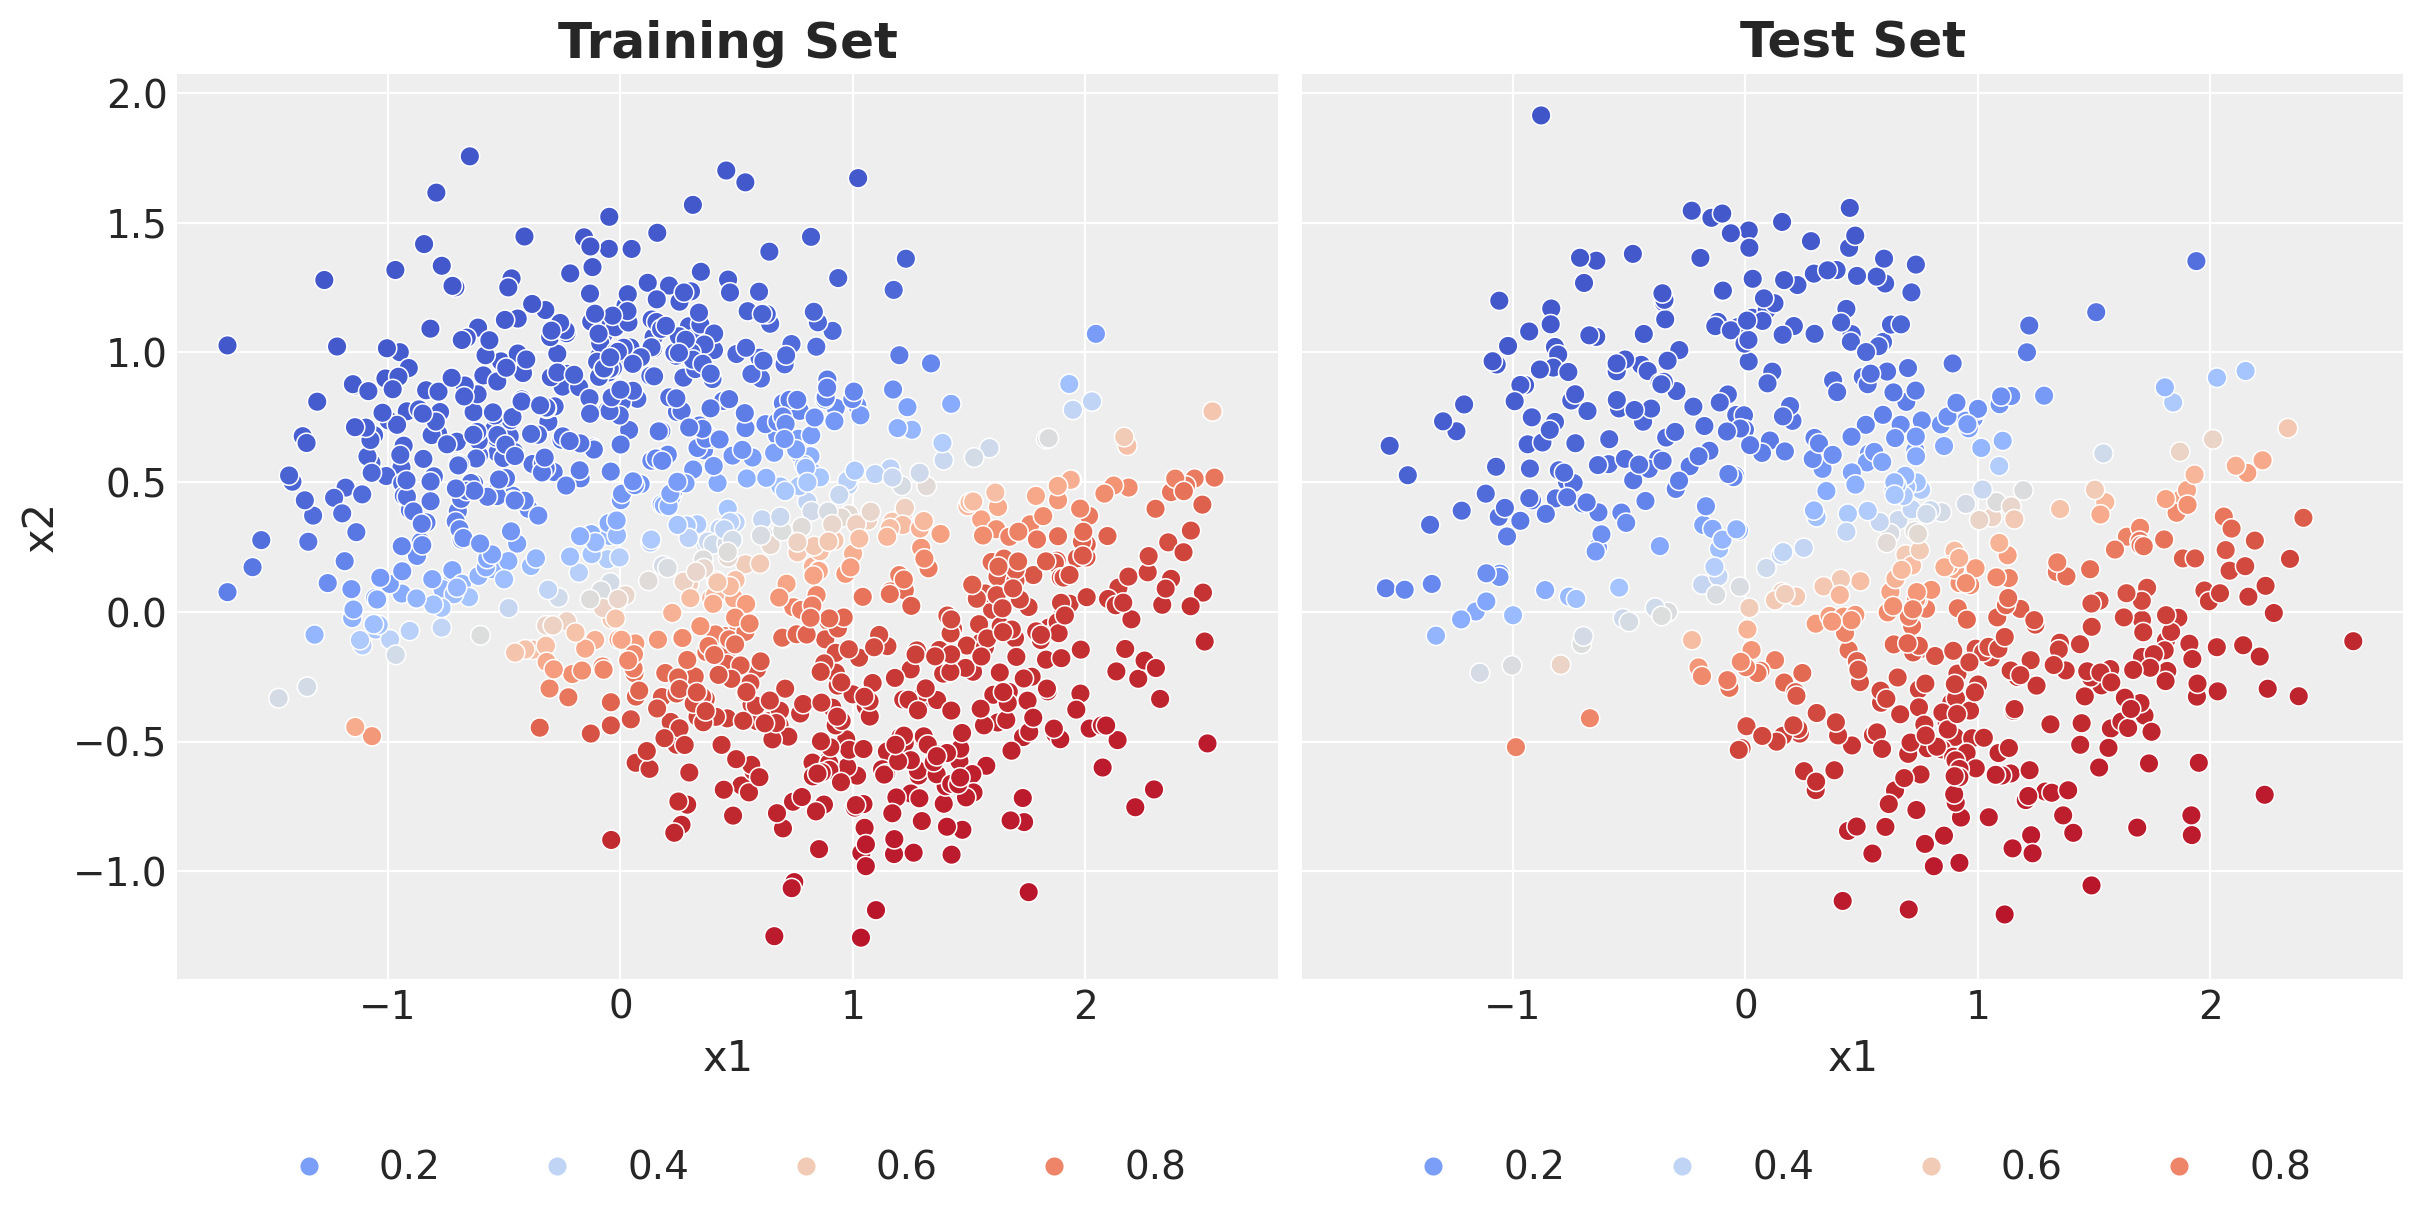

In [20]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 6),
    sharex=True,
    sharey=True,
    layout="constrained",
)

(
    train_idata["posterior_predictive"]["p"]
    .mean(dim=("chain", "draw"))
    .to_pandas()
    .to_frame()
    .assign(x1=x_train[:, 0], x2=x_train[:, 1])
    .pipe(
        (sns.scatterplot, "data"),
        x="x1",
        y="x2",
        hue="p",
        hue_norm=(0, 1),
        palette="coolwarm",
        s=50,
        ax=ax[0],
    )
)

ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
ax[0].set_title("Training Set", fontsize=18, fontweight="bold")

(
    test_idata["posterior_predictive"]["p"]
    .mean(dim=("chain", "draw"))
    .to_pandas()
    .to_frame()
    .assign(x1=x_test[:, 0], x2=x_test[:, 1])
    .pipe(
        (sns.scatterplot, "data"),
        x="x1",
        y="x2",
        hue="p",
        hue_norm=(0, 1),
        palette="coolwarm",
        s=50,
        ax=ax[1],
    )
)

ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
ax[1].set_title("Test Set", fontsize=18, fontweight="bold");